In [85]:
%load_ext autoreload
%autoreload 2

# Simple Calculator with LangGraph

This notebook shows how to create a simple calculator using LangGraph that can perform basic mathematical operations.

In [ ]:
from langchain.agents import tool
from langchain_core.messages import SystemMessage
from qwen_agent.llm.fncall_prompts.nous_fncall_prompt import (
    NousFnCallPrompt,
    Message,
    ContentItem,
)


def langchain_tools_to_qwen_functions(langchain_tools):
    """Convierte herramientas de LangChain al formato de funciones de QWen Agent"""
    functions = []

    for tool in langchain_tools:
        # Obtener el esquema de argumentos de la herramienta
        args_schema = tool.args_schema.schema() if hasattr(tool, "args_schema") else {}

        # Crear la definición de función en el formato esperado por QWen
        function_def = {
            "name": tool.name,
            "description": tool.description,
            "parameters": {
                "type": "object",
                "properties": args_schema.get("properties", {}),
                "required": args_schema.get("required", []),
            },
        }

        functions.append(function_def)

    return functions


# Calculator tools
@tool
def add(a: float, b: float) -> float:
    """Add two numbers."""
    return a + b


@tool
def subtract(a: float, b: float) -> float:
    """Subtract two numbers."""
    return a - b


@tool
def multiply(a: float, b: float) -> float:
    """Multiply two numbers."""
    return a * b


@tool
def divide(a: float, b: float) -> float:
    """Divide two numbers."""
    if b == 0:
        raise ValueError("Cannot divide by zero")
    return a / b


# Tools list
tools = [add, subtract, multiply, divide]

qwen_functions = langchain_tools_to_qwen_functions(tools)

system_message = NousFnCallPrompt().preprocess_fncall_messages(
    messages=[
        Message(
            role="system", content=[ContentItem(text="You are a helpful assistant.")]
        ),
    ],
    functions=qwen_functions,
    lang=None,
)

system_message = system_message[0].model_dump()
contents = [{"type": "text", "text": msg["text"]} for msg in system_message["content"]]
system_message = SystemMessage(content=contents)

In [87]:
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI


# Configure LLM
llm = ChatOpenAI(
    base_url="http://localhost:8000/v1",
    model_name="unsloth/Qwen2.5-VL-7B-Instruct-bnb-4bit",
    openai_api_key="EMPTY",
    temperature=0,
)

# Create the agent using LangGraph prebuilt
app = create_react_agent(llm, tools, prompt=system_message)

print("✅ Calculator with LangGraph configured successfully!")
print("Example usage:")
print("app.invoke({'messages': [HumanMessage(content='What is 15 + 27?')]})")

✅ Calculator with LangGraph configured successfully!
Example usage:
app.invoke({'messages': [HumanMessage(content='What is 15 + 27?')]})


In [88]:
def print_full_history(messages):
    """Prints the full message history, including tool calls if present."""
    print("\nHere is a complete message history:\n")
    print("-" * 40)
    for msg in messages:
        print(f"\nType: {type(msg).__name__}")
        content = getattr(msg, "content", msg)
        if isinstance(content, list):
            content = content[0]["text"] if content else ""
        content = content.replace("\n", " ")
        print(f"Content: {content}")
        # Show tool call info if present
        if hasattr(msg, "tool_calls"):
            for call in msg.tool_calls:
                print(f"Tool Call: '{call['name']}' with args {call['args']}")

        print()
        print("-" * 40)


# Usage examples
print("🧮 Testing the calculator:")
print("-" * 40)

# Example 1: Addition
response = app.invoke({"messages": [HumanMessage(content="What is 15 + 27?")]})
print("Question: What is 15 + 27?")
print(f"Answer: {response['messages'][-1].content}")
print()

# Example 2: Multiplication
response = app.invoke({"messages": [HumanMessage(content="Multiply 8 by 9")]})
print("Question: Multiply 8 by 9")
print(f"Answer: {response['messages'][-1].content}")
print()

# Example 3: Division
response = app.invoke({"messages": [HumanMessage(content="Divide 100 by 4")]})
print("Question: Divide 100 by 4")
print(f"Answer: {response['messages'][-1].content}")
print()

# Example 4: Subtraction
response = app.invoke({"messages": [HumanMessage(content="What is 50 - 23?")]})
print("Question: What is 50 - 23?")
print(f"Answer: {response['messages'][-1].content}")
print()

# Example 5: Error handling (division by zero)
response = app.invoke(
    {"messages": [HumanMessage(content="What happens if I divide 10 by 0?")]}
)
print("Question: What happens if I divide 10 by 0?")
print(f"Answer: {response['messages'][-1].content}")

print_full_history(response["messages"])

🧮 Testing the calculator:
----------------------------------------
Question: What is 15 + 27?
Answer: The sum of 15 and 27 is 42.

Question: Multiply 8 by 9
Answer: The result of multiplying 8 by 9 is 72.

Question: Divide 100 by 4
Answer: The result of dividing 100 by 4 is 25.0.

Question: What is 50 - 23?
Answer: The result of 50 - 23 is 27.

Question: What happens if I divide 10 by 0?
Answer: It seems there was a misunderstanding. When you try to divide a number by zero, it results in an undefined value in mathematics. This is why most mathematical operations and programming languages will throw an error when you attempt to divide by zero. 

In the context of division, dividing 10 by 0 does not yield a real number; instead, it leads to an undefined result. If you need a specific calculation or have another question, feel free to ask!

Here is a complete message history:

----------------------------------------

Type: HumanMessage
Content: What happens if I divide 10 by 0?

--------

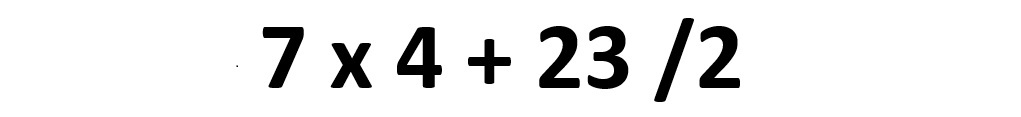

Question: What is the solution of the calculation in the image?

Here is a complete message history:

----------------------------------------

Type: HumanMessage
Content: What is the solution of the equation? You MUST use tools to solve it.

----------------------------------------

Type: AIMessage
Content: Let's break down the expression step by step:  1. First, we need to perform the multiplication: \(7 \times 4\). 2. Then, we add the result to \(23 / 2\).  Let's calculate this using the `multiply` and `add` functions. 
Tool Call: 'multiply' with args {'a': 7, 'b': 4}
Tool Call: 'add' with args {'a': 28, 'b': 11.5}
Tool Call: 'add' with args {'a': 28, 'b': 11.5}
Tool Call: 'add' with args {'a': 28, 'b': 11.5}
Tool Call: 'add' with args {'a': 28, 'b': 11.5}
Tool Call: 'add' with args {'a': 28, 'b': 11.5}
Tool Call: 'add' with args {'a': 28, 'b': 11.5}
Tool Call: 'add' with args {'a': 28, 'b': 11.5}
Tool Call: 'add' with args {'a': 28, 'b': 11.5}
Tool Call: 'add' with args {'a': 28, '

In [94]:
import requests
import base64
from IPython.display import Image, display


image_url = "https://drive.usercontent.google.com/download?id=1ZC9c2unfvMqKDWCWdRFCQ70iKPSEcP-I&export=view&authuser=0"

# Descargar la imagen y convertirla a base64
response_img = requests.get(image_url)
image_base64 = base64.b64encode(response_img.content).decode("utf-8")

# Construir el mensaje con la imagen en base64
# Mostrar la imagen decodificada desde base64
display(Image(data=base64.b64decode(image_base64)))

response = app.invoke(
    {
        "messages": [
            HumanMessage(
                content=[
                    {
                        "type": "text",
                        "text": "What is the solution of the equation? You MUST use tools to solve it.",
                    },
                    {"type": "image_url", "image_url": {"url": image_url}},
                ]
            )
        ]
    }
)

print("Question: What is the solution of the calculation in the image?")
print_full_history(response["messages"])

In [92]:
response["messages"][-1]

AIMessage(content="To solve the expression \\(7 \\times 4 + \\frac{23}{2}\\), we need to follow the order of operations (PEMDAS/BODMAS):\n\n1. Perform multiplication and division from left to right.\n2. Then perform addition and subtraction from left to right.\n\nLet's break it down step by step:\n\n1. Calculate \\(7 \\times 4\\):\n   \\[\n   7 \\times 4 = 28\n   \\]\n\n2. Calculate \\(\\frac{23}{2}\\):\n   \\[\n   \\frac{23}{2} = 11.5\n   \\]\n\n3. Now add the results of the multiplication and division:\n   \\[\n   28 + 11.5 = 39.5\n   \\]\n\nSo, the solution to the expression \\(7 \\times 4 + \\frac{23}{2}\\) is \\(39.5\\).\n\n<tool_call>\n�始", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 202, 'prompt_tokens': 571, 'total_tokens': 773, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'unsloth/Qwen2.5-VL-7B-Instruct-bnb-4bit', 'system_fingerprint': None, 'id': 'chatcmpl-7b9705e22f9c419caa5c3feaac4ddc55', '

In [ ]:
from src.agents import OpenSourceBalatroAgent

agent = OpenSourceBalatroAgent.create(
    model="unsloth/Qwen2.5-VL-7B-Instruct-bnb-4bit",
    mcp_url="http://localhost:8001/mcp",
    max_iterations=10,
)

response = await agent.invoke(
    {
        "messages": [
            HumanMessage(
                content=[
                    {
                        "type": "text",
                        "text": "Start the game and select a hand",
                    }
                ]
            )
        ]
    }
)